<a href="https://colab.research.google.com/github/Yuns-u/pneumonia_classification/blob/main/pneumonia_X_ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pneumonia X-ray Classification
폐렴 x-ray 사진을 판별하는 이미지 분류 딥러닝 모델 만들기

2020년 3월 기준 COVID-19 환자 중 폐렴이 진행되는 경우, CT 촬영을 통한 폐렴유무 판단은 어려운 것이라는 전문가의 소견이 있었다.
(https://www.joongang.co.kr/article/23720884#home)
같은 바이러스성 폐렴임에도 불구하고 코로나 19는 영상 소견으로 최대 82.4%까지 포착할 수 있는 SARS나 83.6%까지 포착할 수 있는 메르스에 비해 포착하기 어렵다고 한다.

# 데이터
해당 이미지 데이터는 총 194개로 상당히 적은 양이다. 
https://www.kaggle.com/khoongweihao/covid19-xray-dataset-train-test-sets

# 프로젝트 목표
이번 프로젝트를 통해 이미지 분류를 딥러닝으로 해결함으로써 딥러닝에 대한 이해도를 높히고자 한다. 또한 80% 이상의 정확도를 가져올 수 있다면 사스나 메르스를 잘 넘긴 우리나리인만큼, 코로나 바이러스의 확산 및 치료에 대한 대책을 마련할 수 있을 것이다.


x-ray 이미지를 통해 정상 폐와 폐렴에 걸린 폐를 분류한다.
폐렴인 경우 positive(1)로, 정상 이미지를 Negative(0)로 레이블링해준다.

In [50]:
#필요한 모듈 불러오기
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import binary_crossentropy

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            '/content/drive/MyDrive/Colab Notebooks/pneumonia_project/xray_dataset_covid19/train',
            labels= "inferred",
            label_mode= "binary",
            image_size=(256, 256), 
            class_names=["NORMAL", "PNEUMONIA"],
            color_mode="grayscale",
            shuffle=False,
            validation_split=0.2,
            subset='training'
        )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            '/content/drive/MyDrive/Colab Notebooks/pneumonia_project/xray_dataset_covid19/test',
            labels= "inferred",
            label_mode= "binary",
            image_size=(256, 256),
            class_names=["NORMAL", "PNEUMONIA"],
            color_mode="grayscale",
            shuffle=False,
            validation_split=0.2,
            subset="validation"
        )


data_list = [train_ds, val_ds]

#라벨링명 확인하기
for i in data_list :
  print(i.class_names)

Found 148 files belonging to 2 classes.
Using 119 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [54]:
for normal_batch, target_batch in train:
  print(normal_batch.shape)
  print(target_batch.shape)
  break

(32, 256, 256, 1)
(32, 1)


- normal_batch는 (32, 256, 256, 1) 형상의 텐서이며, 256x256x1 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). 
- target_batch는 형상 (32,1)의 텐서이며 32개 이미지에 해당하는 레이블입니다.

-> 수정 필요. 이해 필요.

In [55]:
#데이터 표준화
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

map을 호출하여 데이터세트에 레이어를 적용하여 데이터 표준화.
-> 흑백의 이미지인데 이 표준화가 과연 필요한가?

In [56]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.030752147 0.99930304


In [57]:
#성능을 위한 데이터 세트 구성하기

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 기준 모델
전통적인 머신러닝으로도 해당 문제를 해결할 수 있을 것 같다...
찾아보기

# 전처리하지 않고 모델링

어떤 사람의 모델을 보고 따라해본 것.
많이 까먹었다....모델 쌓는 것 전에 개념 정리할 필요 있음.

In [58]:
#initializing the CNN
cnn = tf.keras.models.Sequential()

#convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 1]))

#pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#adding second convolution layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#flattening
cnn.add(tf.keras.layers.Flatten())

#output layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [59]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# 모델 학습 시키기 전 과적합 방지 방안 생각해볼 필요 있음.

In [60]:
history = cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  
)

Epoch 1/10
4/4 [==============================] - 9s 2s/step - loss: 702.0295 - accuracy: 0.3529 - val_loss: 1077.5259 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 7s 2s/step - loss: 125.8495 - accuracy: 0.6218 - val_loss: 52.7988 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 13.6722 - accuracy: 0.6471 - val_loss: 1.9190e-31 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 27.1566 - accuracy: 0.3782 - val_loss: 2.7565e-05 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 2.0016 - accuracy: 0.6807 - val_loss: 0.9590 - val_accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 0.0952 - accuracy: 0.9496 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 7s 2s/step - loss: 0.1886 - accuracy: 0.9244 - val_loss: 0.1032 - val_accuracy: 1.0000
Epoch 8/10
4/4 

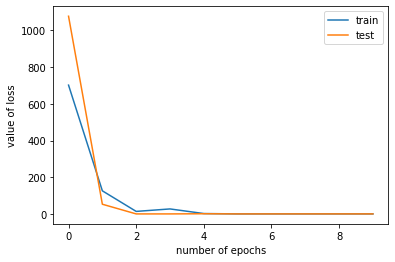

In [61]:
# 학습과정에서 기록된 훈련 데이터의 손실과 테스트 데이터의 손실 히스토리를 시각화할 수 있다.
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('number of epochs')
plt.ylabel('value of loss')
plt.legend()
plt.show()

# 참고자료
- https://www.tensorflow.org/tutorials/load_data/images?hl=ko
-